# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment


# Load Reacher env with 20 agents
# env = UnityEnvironment(file_name='Reacher')
env = UnityEnvironment(
    file_name='/home/arasdar/unity-envs/Reacher_Linux_NoVis_OneAgent/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33


### 3. Instantiate DAQL Agent

In [4]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
GAMMA = 0.99            # discount factor
LR = 1e-3        # learning rate of the critic
BATCH_SIZE = 1024         # minibatch size/ RAM size
BUFFER_SIZE = int(1e6)  # replay buffer size
random_seed = 7 # random seed for result reproducibility
h_size = 400 # hidden layer size

In [6]:
from agent import Agent

agent = Agent(s_size=state_size, a_size=action_size, h_size=400, random_seed=random_seed, gamma=GAMMA, 
              lr=LR, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE, device=device)

### 4. Train the Agent with DAQL

In [7]:
print(env_info.agents, 
env_info.local_done, 
env_info.max_reached,
env_info.memories,
env_info.visual_observations)

[922] [False] [False] [] []


In [8]:
from collections import deque
import numpy as np
import time
import torch

In [9]:
# # n [1]: import torch

# # In [2]: 
print(torch.cuda.current_device())
# # Out[2]: 0

# In [3]: 
print(torch.cuda.device(0))
# Out[3]: <torch.cuda.device at 0x7efce0b03be0>

# In [4]: 
print(torch.cuda.device_count())
# Out[4]: 1

# In [5]: 
print(torch.cuda.get_device_name(0))
# Out[5]: 'GeForce GTX 950M'

# In [6]: 
print(torch.cuda.is_available())
# Out[6]: True

0
1
Quadro P5000
True


In [10]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Quadro P5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [11]:
n_episodes=1000
n_steps=1000
# n_learn=20 # numbe of agents: once per agent
# learn_every=20 # learn every 20 steps/timesteps
R_goal=30 # TOCHECK
Rs_deque = deque(maxlen=100)
list_episodes = []

In [12]:
for i_episode in range(n_episodes):
    
    # Reset Env and Agent
    env_info = env.reset(train_mode=True)[brain_name]       # reset the environment (env)    
    s = env_info.vector_observations[0]                   # get the current state (s) (for an agent)

    R = 0                            # initialize the total score (R) (for an agent)
    list_steps = []

    #for i_step in range(n_steps):
    while True:
        
        #print(s.shape)
        s = np.reshape(s, [1, -1])
        a = agent.act(s) # a: action [-1, +1], s: current state for an agent
        #print(a.shape)
        
        # Exploration noise
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)

        env_info = env.step(a)[brain_name]            # send an action (a) to the environment (env)
        s2 = env_info.vector_observations[0]          # get next state (s) (for an agent)
        r = env_info.rewards[0]                          # get reward (for an agent)
        done = env_info.local_done[0]               # see if episode is done/finished (terminal) for an agent
        #print(s2.shape, r, done)

        # send an exprience (e) to the agent or collecting experiences (E)
        a = np.reshape(a, [-1])
        s = np.reshape(s, [-1])
        agent.memory.add(s, a, r, s2, done)

        R += r                           # update the total score (for an agent)
        s = s2                                # roll over state (s) to next state (s2)

        # if i_step%learn_every == 0:
        # for _ in range(n_learn):
        gloss, dloss, reward, reward_in = agent.start_learn()
        list_steps.append([gloss, dloss, reward, reward_in])
                
        # Exit loop if episode is done/finished for any of the agents among all of them
        if done:
            break

    Rs_deque.append(np.mean(R))
    
    print('Episode:{}, Total Average Score:{:.2f}'.format(i_episode+1, np.mean(Rs_deque)),
          'gloss:{:.2f}'.format(np.mean(list_steps, axis=0)[0]), 
          'dloss:{:.2f}'.format(np.mean(list_steps, axis=0)[1]),
          'reward:{:.5f}'.format(np.mean(list_steps, axis=0)[2]), 
          'reward_in:{:.5f}'.format(np.mean(list_steps, axis=0)[3]))
    
    # Plotting
    list_episodes.append([np.mean(Rs_deque),
                          np.mean(list_steps, axis=0)[0], # gloss
                          np.mean(list_steps, axis=0)[1], # dloss
                          np.mean(list_steps, axis=0)[2], # reward
                          np.mean(list_steps, axis=0)[3]]) # reward_in

    if np.mean(Rs_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-reacher.pth')
        torch.save(agent.d.state_dict(), 'd-reacher.pth')
        break

Episode:1, Total Average Score:0.00 gloss:0.00 dloss:0.00 reward:0.00000 reward_in:0.00000
Episode:2, Total Average Score:0.26 gloss:0.12 dloss:-0.02 reward:0.00002 reward_in:-0.00004
Episode:3, Total Average Score:0.26 gloss:0.31 dloss:-0.02 reward:0.00031 reward_in:0.00001
Episode:4, Total Average Score:0.25 gloss:0.62 dloss:-0.03 reward:0.00023 reward_in:0.00005
Episode:5, Total Average Score:0.33 gloss:1.21 dloss:-0.04 reward:0.00029 reward_in:0.00007
Episode:6, Total Average Score:0.46 gloss:1.52 dloss:-0.06 reward:0.00034 reward_in:0.00009
Episode:7, Total Average Score:0.49 gloss:1.88 dloss:-0.08 reward:0.00048 reward_in:0.00010
Episode:8, Total Average Score:0.53 gloss:2.02 dloss:-0.10 reward:0.00047 reward_in:0.00011
Episode:9, Total Average Score:0.62 gloss:2.27 dloss:-0.12 reward:0.00057 reward_in:0.00012
Episode:10, Total Average Score:0.60 gloss:2.57 dloss:-0.14 reward:0.00060 reward_in:0.00012
Episode:11, Total Average Score:0.69 gloss:2.83 dloss:-0.16 reward:0.00061 rewa

Episode:89, Total Average Score:1.90 gloss:18.42 dloss:-0.76 reward:0.00169 reward_in:0.00011
Episode:90, Total Average Score:1.90 gloss:18.51 dloss:-0.76 reward:0.00189 reward_in:0.00010
Episode:91, Total Average Score:1.91 gloss:18.81 dloss:-0.77 reward:0.00192 reward_in:0.00009
Episode:92, Total Average Score:1.91 gloss:19.27 dloss:-0.77 reward:0.00193 reward_in:0.00008
Episode:93, Total Average Score:1.95 gloss:19.80 dloss:-0.78 reward:0.00192 reward_in:0.00010
Episode:94, Total Average Score:1.93 gloss:20.19 dloss:-0.78 reward:0.00195 reward_in:0.00009
Episode:95, Total Average Score:1.95 gloss:20.60 dloss:-0.79 reward:0.00194 reward_in:0.00009
Episode:96, Total Average Score:1.99 gloss:20.88 dloss:-0.80 reward:0.00197 reward_in:0.00009
Episode:97, Total Average Score:1.97 gloss:21.12 dloss:-0.81 reward:0.00197 reward_in:0.00012
Episode:98, Total Average Score:2.06 gloss:21.19 dloss:-0.82 reward:0.00200 reward_in:0.00010
Episode:99, Total Average Score:2.06 gloss:21.40 dloss:-0.83

Episode:176, Total Average Score:7.70 gloss:39.89 dloss:-1.51 reward:0.00499 reward_in:0.00009
Episode:177, Total Average Score:7.83 gloss:40.07 dloss:-1.52 reward:0.00500 reward_in:0.00010
Episode:178, Total Average Score:7.80 gloss:40.15 dloss:-1.53 reward:0.00502 reward_in:0.00009
Episode:179, Total Average Score:7.82 gloss:40.57 dloss:-1.54 reward:0.00502 reward_in:0.00010
Episode:180, Total Average Score:7.81 gloss:40.74 dloss:-1.55 reward:0.00499 reward_in:0.00010
Episode:181, Total Average Score:7.83 gloss:40.70 dloss:-1.55 reward:0.00496 reward_in:0.00010
Episode:182, Total Average Score:7.98 gloss:40.63 dloss:-1.56 reward:0.00499 reward_in:0.00010
Episode:183, Total Average Score:7.97 gloss:40.76 dloss:-1.56 reward:0.00504 reward_in:0.00011
Episode:184, Total Average Score:8.07 gloss:40.68 dloss:-1.56 reward:0.00500 reward_in:0.00009
Episode:185, Total Average Score:8.26 gloss:40.50 dloss:-1.56 reward:0.00510 reward_in:0.00008
Episode:186, Total Average Score:8.39 gloss:40.55 

Episode:262, Total Average Score:13.25 gloss:39.11 dloss:-1.86 reward:0.00768 reward_in:0.00010
Episode:263, Total Average Score:13.25 gloss:39.27 dloss:-1.86 reward:0.00766 reward_in:0.00009
Episode:264, Total Average Score:13.56 gloss:39.29 dloss:-1.87 reward:0.00771 reward_in:0.00010
Episode:265, Total Average Score:13.78 gloss:39.25 dloss:-1.89 reward:0.00785 reward_in:0.00008
Episode:266, Total Average Score:13.82 gloss:39.65 dloss:-1.90 reward:0.00790 reward_in:0.00010
Episode:267, Total Average Score:13.66 gloss:39.52 dloss:-1.91 reward:0.00798 reward_in:0.00011
Episode:268, Total Average Score:13.66 gloss:39.80 dloss:-1.92 reward:0.00797 reward_in:0.00009
Episode:269, Total Average Score:13.84 gloss:40.04 dloss:-1.93 reward:0.00801 reward_in:0.00009
Episode:270, Total Average Score:13.71 gloss:40.01 dloss:-1.95 reward:0.00809 reward_in:0.00010
Episode:271, Total Average Score:13.67 gloss:40.32 dloss:-1.96 reward:0.00807 reward_in:0.00010
Episode:272, Total Average Score:13.65 g

Episode:348, Total Average Score:19.81 gloss:41.44 dloss:-2.34 reward:0.01069 reward_in:0.00008
Episode:349, Total Average Score:20.18 gloss:41.56 dloss:-2.34 reward:0.01069 reward_in:0.00009
Episode:350, Total Average Score:20.22 gloss:41.61 dloss:-2.35 reward:0.01075 reward_in:0.00010
Episode:351, Total Average Score:20.39 gloss:41.50 dloss:-2.35 reward:0.01074 reward_in:0.00008
Episode:352, Total Average Score:20.45 gloss:41.36 dloss:-2.35 reward:0.01086 reward_in:0.00010
Episode:353, Total Average Score:20.80 gloss:41.42 dloss:-2.36 reward:0.01091 reward_in:0.00010
Episode:354, Total Average Score:20.78 gloss:41.98 dloss:-2.36 reward:0.01094 reward_in:0.00010
Episode:355, Total Average Score:20.45 gloss:42.33 dloss:-2.37 reward:0.01099 reward_in:0.00011
Episode:356, Total Average Score:20.60 gloss:42.20 dloss:-2.37 reward:0.01101 reward_in:0.00010
Episode:357, Total Average Score:20.61 gloss:42.29 dloss:-2.38 reward:0.01103 reward_in:0.00011
Episode:358, Total Average Score:20.69 g

Episode:434, Total Average Score:25.33 gloss:45.44 dloss:-2.69 reward:0.01367 reward_in:0.00010
Episode:435, Total Average Score:25.01 gloss:45.52 dloss:-2.70 reward:0.01367 reward_in:0.00012
Episode:436, Total Average Score:24.98 gloss:45.34 dloss:-2.70 reward:0.01366 reward_in:0.00009
Episode:437, Total Average Score:24.97 gloss:45.47 dloss:-2.70 reward:0.01367 reward_in:0.00010
Episode:438, Total Average Score:24.96 gloss:45.48 dloss:-2.70 reward:0.01375 reward_in:0.00011
Episode:439, Total Average Score:24.94 gloss:45.29 dloss:-2.70 reward:0.01381 reward_in:0.00011
Episode:440, Total Average Score:25.32 gloss:45.03 dloss:-2.70 reward:0.01385 reward_in:0.00010
Episode:441, Total Average Score:25.26 gloss:44.77 dloss:-2.70 reward:0.01390 reward_in:0.00009
Episode:442, Total Average Score:25.26 gloss:45.19 dloss:-2.70 reward:0.01391 reward_in:0.00010
Episode:443, Total Average Score:25.64 gloss:44.97 dloss:-2.70 reward:0.01391 reward_in:0.00011
Episode:444, Total Average Score:25.69 g

Episode:520, Total Average Score:26.95 gloss:40.93 dloss:-2.76 reward:0.01604 reward_in:0.00011
Episode:521, Total Average Score:26.94 gloss:40.89 dloss:-2.76 reward:0.01611 reward_in:0.00012
Episode:522, Total Average Score:27.33 gloss:40.68 dloss:-2.76 reward:0.01611 reward_in:0.00011
Episode:523, Total Average Score:27.33 gloss:40.55 dloss:-2.75 reward:0.01617 reward_in:0.00011
Episode:524, Total Average Score:27.61 gloss:40.56 dloss:-2.75 reward:0.01619 reward_in:0.00010
Episode:525, Total Average Score:27.63 gloss:40.38 dloss:-2.75 reward:0.01621 reward_in:0.00011
Episode:526, Total Average Score:27.62 gloss:40.06 dloss:-2.75 reward:0.01627 reward_in:0.00010
Episode:527, Total Average Score:27.61 gloss:40.24 dloss:-2.75 reward:0.01627 reward_in:0.00010
Episode:528, Total Average Score:27.67 gloss:40.00 dloss:-2.75 reward:0.01636 reward_in:0.00011
Episode:529, Total Average Score:28.03 gloss:39.86 dloss:-2.75 reward:0.01638 reward_in:0.00011
Episode:530, Total Average Score:28.04 g

### 5. Plot the result

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# arr = np.array(list_episodes).T[0]

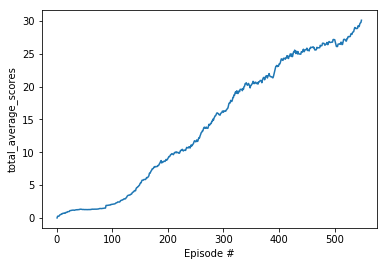

In [17]:
arr = np.array(list_episodes).T[0]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(arr)+1), arr)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

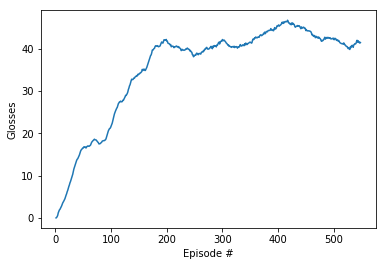

In [18]:
arr = np.array(list_episodes).T[1]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(arr)+1), arr)
plt.ylabel('Glosses')
plt.xlabel('Episode #')
plt.show()

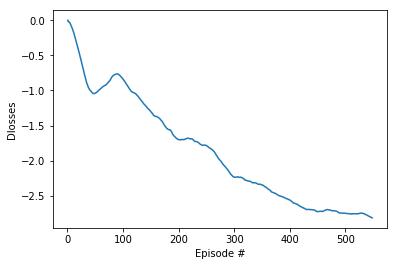

In [19]:
arr = np.array(list_episodes).T[2]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(arr)+1), arr)
plt.ylabel('Dlosses')
plt.xlabel('Episode #')
plt.show()

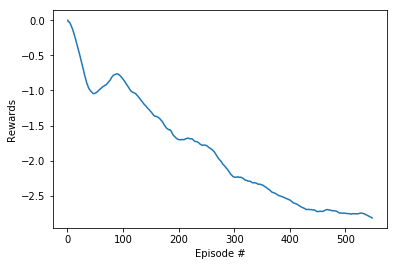

In [20]:
arr = np.array(list_episodes).T[2]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(arr)+1), arr)
plt.ylabel('Rewards')
plt.xlabel('Episode #')
plt.show()

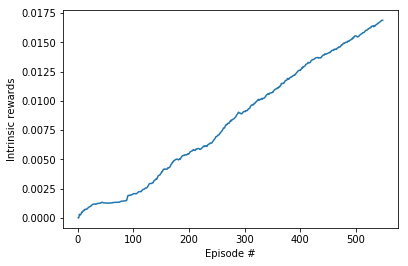

In [21]:
arr = np.array(list_episodes).T[3]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(arr)+1), arr)
plt.ylabel('Intrinsic rewards')
plt.xlabel('Episode #')
plt.show()

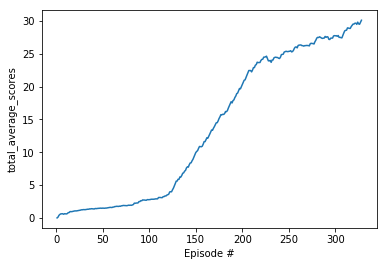

In [8]:
# arr = np.array(list_episodes).T[0]
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)

# plt.plot(np.arange(1, len(arr)+1), arr)
# plt.ylabel('total_average_scores')
# plt.xlabel('Episode #')
# plt.show()

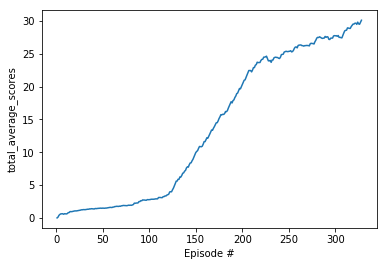

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

In [14]:
glosses = np.array(losses)[:, 0]

In [18]:
dlosses = -np.array(losses)[:, 1]

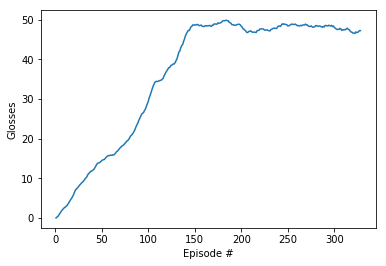

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(glosses)+1), glosses)
plt.ylabel('Glosses')
plt.xlabel('Episode #')
plt.show()

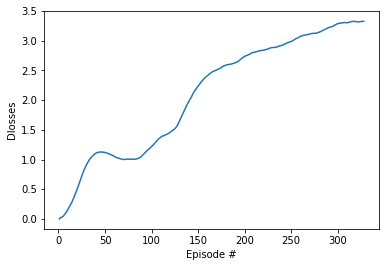

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('Dlosses')
plt.xlabel('Episode #')
plt.show()

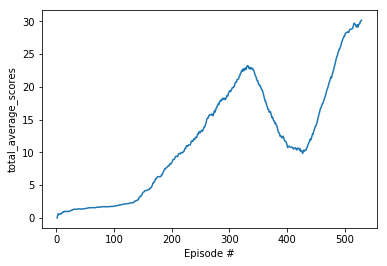

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

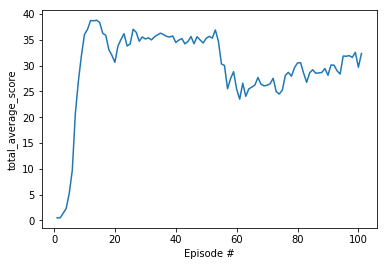

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

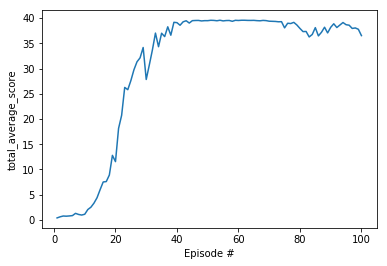

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

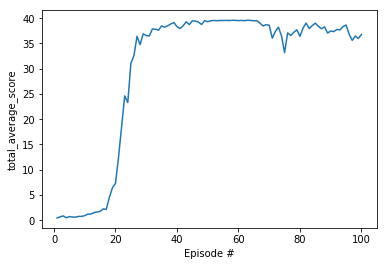

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

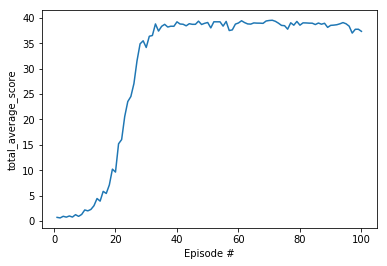

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

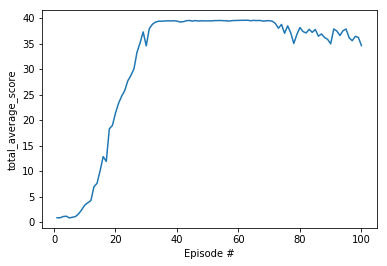

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

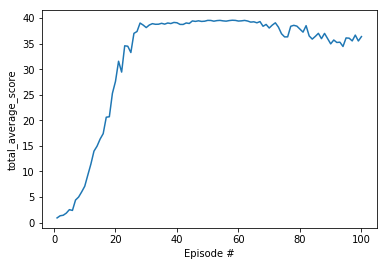

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

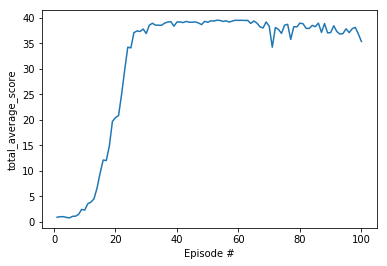

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

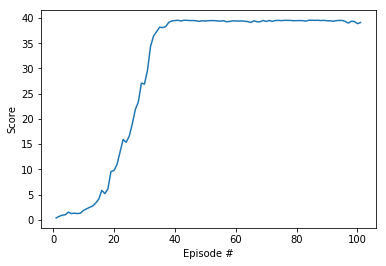

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

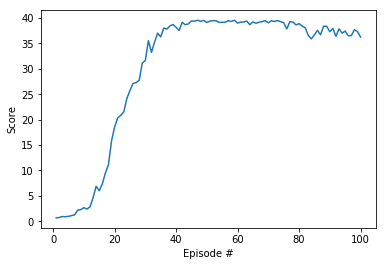

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

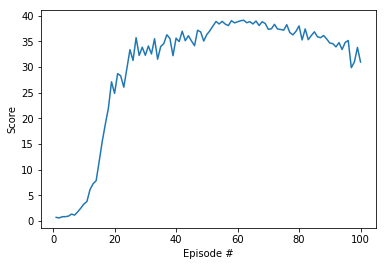

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

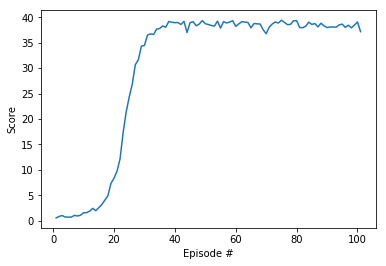

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

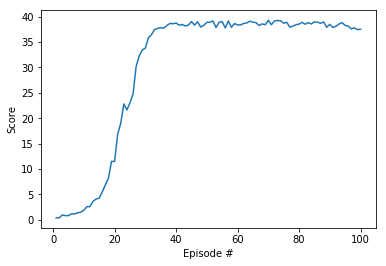

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

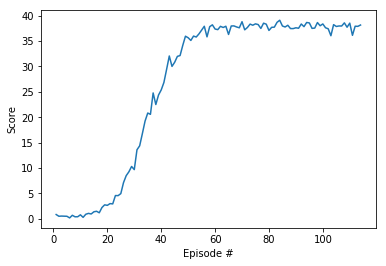

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

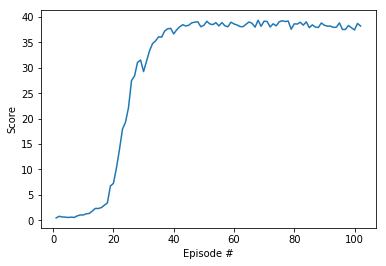

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [22]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-reacher.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-reacher.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment (env)
s = env_info.vector_observations[0]                  # get the current state (s) (for an agent)

R = 0                          # initialize the total score (R) (for an agent)

while True:
    s = np.reshape(s, [1, -1])
    a = agent.act(s) # select action (a) from loaded model agent
    
    env_info = env.step(a)[brain_name]           # send an action (a) to the environment (env)
    s2 = env_info.vector_observations[0]         # get next state (s2) (for an agent)
    r = env_info.rewards[0]                     # get reward (for an agent)
    done = env_info.local_done[0]               # see if the episode is done/finished (terminal) for an agent
    
    R += r                         # update the total score (R) (for an agent)
    s = s2                               # roll over current state (s) to next state (s2)
    
    if done:                        # exit loop if episode is done/finished for an agent
        break
        
print('Average of total scores: {}'.format(R))

Average of total scores: 27.60999938286841


When finished, you can close the environment.

In [23]:
env.close()